In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph, END
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver



In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [4]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):
    decision = interrupt(
        {
            "type":"approval",
            "Reason": "Model is about to answer a user question",
            "question": state['messages'][-1].content,
            "instruction": "Approve this question ? yes/no"
            
        }
    )
    
    if decision['approved'] == 'no':
        return {"messages" : [AIMessage(content="Not approved.")]}
    else: 
        
        response = llm.invoke(state["messages"])
        return {"messages" : [response]}

In [6]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

checkpointer = MemorySaver()

app = builder.compile(checkpointer=checkpointer)

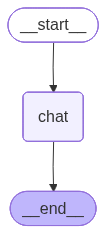

In [7]:
app

In [8]:
config = {"configurable": {"thread_id": '1234'}}

initial_input = {
    "messages" : [
        ("user", "Explain gradient descent in very simple way.")
    ]
}

result = app.invoke(initial_input, config=config)
print(result)

{'messages': [HumanMessage(content='Explain gradient descent in very simple way.', additional_kwargs={}, response_metadata={}, id='4a289ea7-c886-452b-aef9-3fb7dec336d2')], '__interrupt__': [Interrupt(value={'type': 'approval', 'Reason': 'Model is about to answer a user question', 'question': 'Explain gradient descent in very simple way.', 'instruction': 'Approve this question ? yes/no'}, id='796bf3aad26576739ae56d6b3cf651ef')]}


In [9]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple way.', additional_kwargs={}, response_metadata={}, id='4a289ea7-c886-452b-aef9-3fb7dec336d2')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'Reason': 'Model is about to answer a user question', 'question': 'Explain gradient descent in very simple way.', 'instruction': 'Approve this question ? yes/no'}, id='796bf3aad26576739ae56d6b3cf651ef')]}

In [10]:
message = result['__interrupt__']
message[0].value

{'type': 'approval',
 'Reason': 'Model is about to answer a user question',
 'question': 'Explain gradient descent in very simple way.',
 'instruction': 'Approve this question ? yes/no'}

In [11]:
user_input = input(f"\nBackend message - {message} \n Approve this question ?")

In [12]:
# Resume graph with approval decision
final_result = app.invoke(
    Command(resume={"approved":user_input}),
    config=config
)

In [13]:
print(final_result)

{'messages': [HumanMessage(content='Explain gradient descent in very simple way.', additional_kwargs={}, response_metadata={}, id='4a289ea7-c886-452b-aef9-3fb7dec336d2'), AIMessage(content='Imagine you\'re **blindfolded** and standing somewhere on a **hilly terrain**. Your goal is to find the **absolute lowest point** in the entire area – the bottom of the valley.\n\nYou can\'t see, so how do you find your way down?\n\n1.  **Feel the Slope (The Gradient):** You feel the ground around you. Which way is downhill? Is it steeper to your left, or straight ahead? You figure out the direction where the ground slopes downwards the most. This "feeling the slope" and finding the steepest downhill path is like calculating the **gradient**.\n\n2.  **Take a Step (The Descent):** Once you know the steepest downhill direction, you take a small step in that direction.\n\n3.  **Repeat:** You repeat this process:\n    *   Feel the new slope at your new location.\n    *   Take another step in the steepes